In [1]:
import readers.temporal as temp

<link rel="stylesheet" type="text/css" media="all" href="input/temporal/style.css" />

# Temporal Learning

Several temporal planner attempts to exploit classical planning techniques for temporal planning. More precisely, they convert the temporal domain to a classical domain, generate a plan using the classical domain, and use scheduling techniques to make the plan compatible with durative actions. Our approach takes up this idea. After having query the system to be modeled and having built the sample containing temporal sequences (including both feasible and infeasible sequences) we convert the sample into a sample containing non-temporal sequences, we then use the AMLSI algorithm to learn an intermediate classical PDDL domain, finally we convert the learnt domain into a Temporal PDDL domain.

![Feasible sequence](input/temporal/amlsi_temporal.png)

## Temporal Planning

In the context of temporal planning, the action set $A$ consists of durative action $a \in A$ composed of:

* $d_a$; the duration
* $\rho_a(s), \rho_a(e), \rho_a(o)$: precondition of $a$ at start, over all, and at end, respectively.
* $\epsilon^{+}_a(s), \epsilon^{+}_a(e)$: positive effects of $a$ at start and at end, respectively.
* $\epsilon^{-}_a(s), \epsilon^{-}_a(e)$: negative effects of $a$ at start and at end, respectively.

Although $a$ has a duration, its effects apply instantaneously at the start and end of $a$, respectively. The preconditions $\rho_a(s)$ and $\rho_a(e)$ are also checked instantaneously, but $\rho_a(o)$ has to hold for the entire duration of $a$.

The semantics of temporal actions can be defined in terms of two discrete events $start(a)$ and $end(a)$, each of which is naturally expressed as a classical action.

$$\rho_{start(a)} = \rho_a(s) \epsilon^{+}_{start(a)} = \epsilon^{+}_a(s) \epsilon^{-}_{start(a)} = \epsilon^{-}_a(s)$$
$$\rho_{end(a)} = \rho_a(e) \epsilon^{+}_{end(a)} = \epsilon^{+}_a(e) \epsilon^{-}_{end(a)} = \epsilon^{-}_a(e)$$

Starting temporal action $a$ in state $s$ is equivalent to applying the classical action $start(a)$ in $s$, first verifying that $\rho_{start(a)}$ holds in $s$. Ending $a$ in state $s'$ is equivalent to
applying $end(a)$ in $s'$ , first verifying that $\rho_{end(a)}$ holds in $s'$. The duration $d(a)$ and precondition over all $\rho_a(o)$ impose restrictions on this process: $end(a)$ has to occur exactly $d(a)$ time units after $start(a)$ and $\rho_a(o)$ has to hold in all states between $start(a)$ and $end(a)$.

Finally, a temporal action sequence is a set of action-time pairs
$$
\pi = \{(a_1 , t_1 ), \ldots , (a_n , t_n )\}
$$

Each action-time pair $(a, t) \in \pi$ is composed of a temporal action $a \in A$ and a scheduled start time $t$ of $a$, and induces two events $start(a)$ and $end(a)$ with associated timestamps $t$ and $t+d(a)$, respectively.

## Sample Conversion

Let's take a sample containing $\pi^{+}$ and $\pi^{-}$, $\pi^{+}$ (resp $\pi^{-}$) being a positive (resp negative) temporal sequence such that:

$\pi^{+}= \{(0,LIGHT\_MATCH(m)), (0.5,MEND\_FUSE(f_1,m)),(2.6,MEND\_FUSE(f_2,m))\}$
$\pi^{-}= \{(0,LIGHT\_MATCH(m)), (0.5,MEND\_FUSE(f_1,m)), (2.6,MEND\_FUSE(f_2,m)), (4.8,MEND\_FUSE(f_3,m))\}$

 <div class="row">
  <div class="column">
    <img src="input/temporal/match_sequence_feasible.png" alt="Snow" style="width:50%">
  </div>
  <div class="column">
    <img src="input/temporal/match_sequence_unfeasible.png" alt="Forest" style="width:50%">
  </div>
</div> 

We can convert each durative action in the following way: each durative action $a$ is converted into two event actions $start(a)$ and $end(a)$. AFter conversion, we have the following sample:

$\pi_{seq}^{+}= \{start(LIGHT\_MATCH(m)), start(MEND\_FUSE(f_1,m)), end(MEND\_FUSE(f_1,m)), start(MEND\_FUSE(f_2,m)), end(MEND\_FUSE(f_2,m)), end(LIGHT\_MATCH(m))\}$
$\pi_{seq}^{-}= \{start(LIGHT\_MATCH(m)), start(MEND\_FUSE(f_1,m)), end(MEND\_FUSE(f_1,m)), start(MEND\_FUSE(f_2,m)), end(MEND\_FUSE(f_2,m)), start(MEND\_FUSE(f_3,m))\}$


## Domain Conversion

We convert durative action's preconditions and effects in the following way:

$$\rho_{start(a)} = \rho_a(s) \cap \rho_a(o),~\epsilon^{+}_{start(a)} = \epsilon^{+}_a(s),~\epsilon^{-}_{start(a)} = \epsilon^{-}_a(s)$$
$$\rho_{end(a)} = \rho_a(e) \cap \rho_a(o),~\epsilon^{+}_{end(a)} = \epsilon^{+}_a(e),~\epsilon^{-}_{end(a)} = \epsilon^{-}_a(e)$$

We convert sequential action's peconditions and effects in the following way:
$$\rho_a(s)=\rho_{start(a)}\setminus\rho_{end(a)},~\epsilon^{+}_a(s)=\epsilon^{+}_{start(a)},~\epsilon^{-}_a(s)=\epsilon^{-}_{start(a)}$$
$$\rho_a(e)=\rho_{end(a)}\setminus\rho_{start(a)},~\epsilon^{+}_e(s)=\epsilon^{+}_{end(a)},~\epsilon^{-}_e(s)=\epsilon^{-}_{end(a)}$$
$$\rho_a(o)=\rho_{start(a)}\cap\rho_{end(a)}$$

<img src="input/temporal/domain_conversion2.png" alt="Snow" style="width:40%">

## Domain Learning

### Operator Generation

#### Precondition generation

The preconditions of an operator $o$ are the set intersection of all the labels $\mu_A(n, a)$ such that $a$ is an instance of $o$. Formally, $p \in \rho_o$ if and only if for all $a$ instance of $o$ and for all nodes $n$ such that $a$ is an outgoing edge of $n$, $p \in \mu_A(n, a)$.

#### Effect generation

The negative effects $\epsilon_o^{-}$ of an operator $o$ are computed as the set intersection of the propositions present before the execution of all the actions $a$ instances of $o$, and never after. Formally, $p \in \epsilon_o^{-}$ if and only if for all $a$ instance of $o$ and for all couple of nodes $(n,n')$ such that $a$ is both the outgoing edge of $n$ and the incoming edge of $n'$: \[p \in \mu_A(n,a)\wedge p \notin \mu_P(n',a)\] The positive effects $\epsilon_o^{+}$ of an operator $o$ is computed similarly: $p \in \epsilon_o^{+}$ if and only if for all $a$ instance of $o$ and for all couple of nodes $(n,n')$ such that $a$ is both the outgoing edge of $n$ and the incoming edge of $n'$: \[p \notin \mu_A(n,a)\wedge p \in \mu_P(n',a)\]

### Operator Refinement

#### Precondition refinement

In this step, we assume that the propositions of the negative effects must be in the action preconditions. Thus for each negative effect in an operator, we add the corresponding proposition in the preconditions. For instance, suppose $(at\_robby~?from) \in \epsilon^{-}_{move(?from~?to)}$, then $(at\_robby~?from) \in \rho_{move(?from~?to)}$ after refinement.

#### Effect refinement

This step ensures that the generated operators allow to regenerate the induced grammar. We use the labels $\mu_A$ to verify that for each couple of consecutive actions $a$ and $a'$ 
in nodes $n, n'$ in the automaton, the effects of action $a$ applied in the node $n$ allow to satisfy preconditions of the action $a'$. If it is not the case, we add in the effects of $a$ the propositions satisfying the preconditions of $a'$. Also, this step ensures that each time we execute a start action in a node of the automaton then it is possible to execute the corresponding end action.

#### Tabu search

Finally, we perform a Tabu Search to improve the PDDL operators independently of the induced grammar, on which operator generation is based.

The neighborhood of a candidate domain $D$ is the set of domains where a precondition or an effect is added or removed in one operator of $D$. And the search space of the Tabu Search is the set of all possible domains compatible with the following syntax constraints:
* $\rho_a \cap \epsilon{+}_a = \emptyset$
* $\epsilon{-}_a \cap \epsilon{+}_a = \emptyset$
* $\epsilon{-}_{start(a)} \cap \rho_{end(a)} = \emptyset$
* $\epsilon{+}_{start(a)} \cap \epsilon{+}_{end(a)} = \emptyset$
* $\epsilon{-}_{start(a)} \cap \epsilon{-}_{end(a)} = \emptyset$

The fitness score used to evaluate a candidate set $D$ of PDDL operators is:

$$
J(D | I^{seq}_{+}, I^{seq}_{-}, I^{temp}_{+}, I^{temp}_{-}) = J_\rho(D | I^{seq}_{+}) + J_\epsilon(D | I^{seq}_{+}) + J^{+}(D | I^{temp}_{+}) + J^{-}(D | I^{temp}_{-})
$$

where :
* $J_\rho(D | I^{seq}_{+}) = \sum\limits_{\pi \in I^{seq}_{+}} \sum\limits_{(s,a) \in \Gamma(s_0, \pi)} Accept(\rho_a, s) - Reject(\rho_a, s)$
* $J_\epsilon(D | I^{seq}_{+}) = \sum\limits_{\pi \in I^{seq}_{+}} \sum\limits_{(s,a,s') \in \Gamma(s_0, \pi)} Equal(s', \gamma(s,a)) - Different(s', \gamma(s,a))$
* $J^{+}(D | I^{temp}_{+}) = \sum\limits_{\pi \in I_{+}} |\pi| \times 1_{Accept(D, \pi)}$ 
* $J^{-}(D | I^{temp}_{-}) = \sum\limits_{\pi \in I_{-}} 1_{Accept(D, \pi_{+}) \wedge Reject(D, \pi)}$.

## Results

## Peg Solitaire

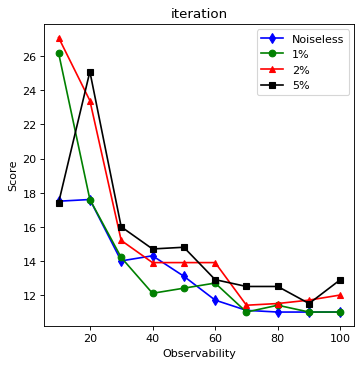

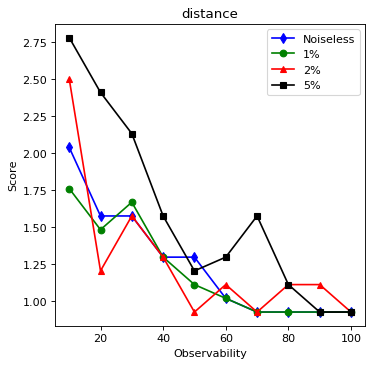

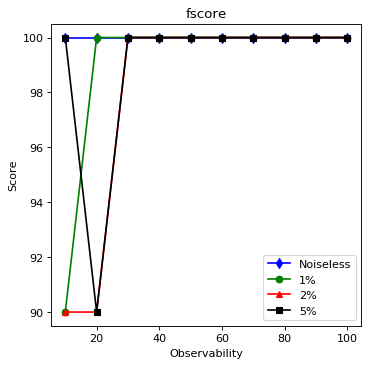

In [7]:
reader=temp.Reader("peg", directory="../temporal")
reader.plot("peg", metric="iteration", repsave="plot/temporal")
reader.plot("peg", metric="distance", repsave="plot/temporal")
reader.plot("peg", metric="fscore", repsave="plot/temporal")

## Match

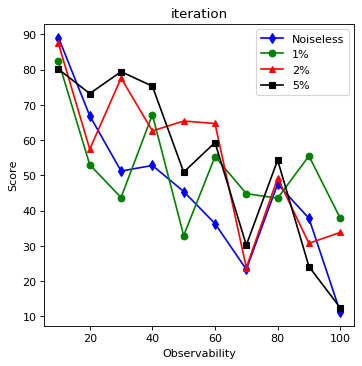

In [8]:
reader=temp.Reader("match", directory="../temporal")
reader.plot("match", metric="iteration", repsave="plot/temporal")
reader.plot("match", metric="distance", repsave="plot/temporal")
reader.plot("match", metric="fscore", repsave="plot/temporal")